In [1]:
import sys
sys.path.append("../src")

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, ClusterData, ClusterLoader
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, SAGEConv
from torch_geometric.utils import remove_self_loops

%load_ext autoreload
%autoreload 2

from data import *
from loader import *
from model import *

import matplotlib.pyplot as plt
import pickle
import random
from scipy.stats import binned_statistic, median_abs_deviation
device = "cuda"


In [2]:
def get_train_valid_indices(data, k, K=3, boxsize=205/0.6774, pad=10, epsilon=1e-10):
    """k must be between `range(0, K)`. 

    `boxsize` and `pad` are both in units of Mpc, and it is assumed that the 
    `data` object has attribute `pos` of shape (N_rows, 3) also in units of Mpc.

    `epsilon` is there so that the modular division doesn't cause the boolean
    logic to wrap around.
    """

    # use z coordinate for train-valid split
    train_1_mask = (
        (data.pos[:, 2]  > ((k) / K * boxsize + pad) % boxsize) 
        & (data.pos[:, 2] <= ((k + 1) / K * boxsize - epsilon) % boxsize)
    )

    train_2_mask = (
        (data.pos[:, 2]  > ((k + 1)/ K * boxsize) % boxsize) 
        & (data.pos[:, 2] <= ((k + 2) / K * boxsize - pad) % boxsize)
    )

    valid_mask = (
        (data.pos[:, 2] > ((k + 2) / K * boxsize) % boxsize)
        & (data.pos[:, 2] <= ((k + 3) / K * boxsize - epsilon) % boxsize)
    )

    # this is the weird pytorch way of doing `np.argwhere`
    train_indices = (train_1_mask  | train_2_mask).nonzero(as_tuple=True)[0] 

    valid_indices = valid_mask.nonzero(as_tuple=True)[0]

    # ensure zero overlap
    assert (set(train_indices) & set(valid_indices)) == set()

    return train_indices, valid_indices


def train(dataloader, model, optimizer, device, augment=True, max_grad_norm=None):
    """Train GNN model using Gaussian NLL loss."""
    model.train()

    loss_total = 0
    for data in (dataloader):
        if augment: # add random noise
            data_node_features_scatter = 3e-3 * torch.randn_like(data.x[:, :2]) * torch.std(data.x[:, :2], dim=0)
            data_edge_features_scatter = 3e-3 * torch.randn_like(data.edge_attr) * torch.std(data.edge_attr, dim=0)
            
            data.x[:, :2] += data_node_features_scatter
            data.edge_attr += data_edge_features_scatter

            assert not torch.isnan(data.x).any() 
            assert not torch.isnan(data.edge_attr).any() 

        data.to(device)

        optimizer.zero_grad()
        y_pred, logvar_pred = model(data).chunk(2, dim=1)
        assert not torch.isnan(y_pred).any() and not torch.isnan(logvar_pred).any()

        y_pred = y_pred.view(-1, model.n_out)
        logvar_pred = logvar_pred.mean()
        loss = 0.5 * (F.mse_loss(y_pred, data.y) / 10**logvar_pred + logvar_pred)

        loss.backward()
        # use gradient clipping to prevent exploding gradients
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        loss_total += loss.item()

    return loss_total / len(dataloader)


def validate(dataloader, model, device):
    model.eval()

    loss_total = 0

    y_preds = []
    y_trues = []
    subhalo_ids = []

    is_central = []

    for data in (dataloader):
        with torch.no_grad():
            data.to(device)
            y_pred, logvar_pred = model(data).chunk(2, dim=1)
            y_pred = y_pred.view(-1, model.n_out)
            logvar_pred = logvar_pred.mean()
            loss = 0.5 * (F.mse_loss(y_pred, data.y) / 10**logvar_pred + logvar_pred)

            loss_total += loss.item()
            y_preds += list(y_pred.detach().cpu().numpy())
            y_trues += list(data.y.detach().cpu().numpy())
            subhalo_ids += list(data.subhalo_id.detach().cpu().numpy())
            is_central += list(data.is_central.detach().cpu().numpy())

    y_preds = np.concatenate(y_preds)
    y_trues = np.array(y_trues)
    subhalo_ids = np.array(subhalo_ids)

    return (
        loss_total / len(dataloader),
        y_preds,
        y_trues,
        subhalo_ids,
        is_central,
    )
    
def configure_optimizer(model, lr, wd,):
    """Only apply weight decay to weights, but not to other
    parameters like biases or LayerNorm. Based on minGPT version.
    """

    decay, no_decay = set(), set()
    yes_wd_modules = (nn.Linear, )
    no_wd_modules = (nn.LayerNorm, )
    for mn, m in model.named_modules():
        for pn, p in m.named_parameters():
            fpn = '%s.%s' % (mn, pn) if mn else pn
            if pn.endswith('bias'):
                no_decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, yes_wd_modules):
                decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, no_wd_modules):
                no_decay.add(fpn)
    param_dict = {pn: p for pn, p in model.named_parameters()}

    optim_groups = [
        {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": wd},
        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.},
    ]

    optimizer = torch.optim.AdamW(
        optim_groups, 
        lr=lr, 
    )

    return optimizer

## create data

In [9]:
if not os.path.exists("merger_trees.pkl"):
    subhalos = prepare_subhalos()
    trees = load_trees()

    merger_trees = make_merger_tree_graphs(trees, subhalos)

    with open('merger_trees.pkl', 'wb') as f:
        pickle.dump(merger_trees, f)
else:
    with open("merger_trees.pkl", "rb") as f:
        merger_trees = pickle.load(f)

In [10]:
subhalos = prepare_subhalos()

/home/john/miniforge3/envs/pyg/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/john/miniforge3/envs/pyg/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/john/miniforge3/envs/pyg/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/john/miniforge3/envs/pyg/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/john/miniforge3/envs/pyg/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/john/miniforge3/env

In [11]:
subhalos.shape

(132953, 36)

In [12]:
subhalo_ids = [t.root_subhalo_id for t in merger_trees]

In [13]:
subhalos_matched = subhalos.set_index("subhalo_id_DMO").loc[subhalo_ids].reset_index()
subhalos_matched.sample(5, random_state=42)

,subhalo_id_DMO,halo_id_DMO,subhalo_flag_DMO,subhalo_x_DMO,subhalo_y_DMO,subhalo_z_DMO,subhalo_vx_DMO,subhalo_vy_DMO,subhalo_vz_DMO,subhalo_n_stellar_particles_DMO,...,subhalo_l_halo_tree,subhalo_sublink,subhalo_gasmetallicity,subhalo_starmetallicity,subhalo_logstellarmass,subhalo_loghalomass,subhalo_logvmax,subhalo_logstellarhalfmassradius,subhalo_loggasmass,subhalo_logsfr
84140,1076366,47096,1.0,80.491241,1.255183,51.310043,168.000351,152.824326,348.584442,0.0,...,1076366,1076366,10.889073,10.583579,7.075147,10.429725,1.655407,0.841946,-1.368958,-inf
9149,288138,48,1.0,60.666241,1.591219,106.235306,-317.873901,187.031342,-239.726425,0.0,...,288138,288138,-inf,10.262707,7.032314,10.257652,1.697610,0.813626,-inf,-inf
21049,652009,1140,1.0,70.743484,69.010101,35.795410,234.298660,-12.824073,460.436157,0.0,...,652009,652009,12.093330,12.022840,9.653987,10.984169,2.025682,0.464863,-0.216207,-0.302472
30515,1183024,93294,1.0,5.631690,47.502159,28.523176,-117.015388,-517.746399,-71.487411,0.0,...,1183024,1183024,10.892797,10.626128,6.828242,10.043495,1.649552,0.550393,-1.901466,-inf
21287,344433,79,1.0,46.824471,48.394192,9.236924,-398.926117,246.120789,-78.790710,0.0,...,344433,344433,12.127279,11.992827,9.144002,10.865140,1.956919,-0.198034,-0.550534,-0.696709


In [14]:
subhalos_matched.shape

(111197, 36)

In [15]:
subhalos_matched.to_parquet("subhalos_in_trees.parquet");

## make and save cosmic graph

In [16]:
subhalos_matched = pd.read_parquet("subhalos_in_trees.parquet")

In [17]:
data = make_cosmic_graph(subhalos_matched, D_link=3)
data

/home/john/research/assembly-vs-environment/notebook/../src/loader.py:81: RuntimeWarning: invalid value encountered in divide
  unitdiff = diff/dist.reshape(-1,1)
/home/john/research/assembly-vs-environment/notebook/../src/loader.py:94: RuntimeWarning: invalid value encountered in divide
  vel_unitdiff = vel_diff / vel_norm.reshape(-1,1)
/home/john/research/assembly-vs-environment/notebook/../src/loader.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index=torch.tensor(target_nodes),


Data(x=[111197, 3], edge_index=[2, 5047487], edge_attr=[5047487, 6], y=[111197, 1], pos=[111197, 3], vel=[111197, 3], is_central=[111197, 1], x_hydro=[111197, 2], pos_hydro=[111197, 3], vel_hydro=[111197, 3], halfmassradius=[111197, 1], subhalo_id=[111197], overdensity=[111197])

In [18]:
# what fraction are centrals?
data.is_central.float().mean()

tensor(0.8215)

In [19]:
with open('cosmic_graphs.pkl', 'wb') as f:
    pickle.dump(data, f)

## train cosmic graph

In [20]:
with open('cosmic_graphs.pkl', 'rb') as f:
    data = pickle.load(f)
    
data

Data(x=[111197, 3], edge_index=[2, 5047487], edge_attr=[5047487, 6], y=[111197, 1], pos=[111197, 3], vel=[111197, 3], is_central=[111197, 1], x_hydro=[111197, 2], pos_hydro=[111197, 3], vel_hydro=[111197, 3], halfmassradius=[111197, 1], subhalo_id=[111197], overdensity=[111197])

In [5]:
node_features = data.x.shape[1]
edge_features = data.edge_attr.shape[1]
out_features = data.y.shape[1]

n_layers = 1
n_hidden = 64
n_latent = 16
n_unshared_layers = 64

aggr="multi"

In [6]:
lr = 3e-3
wd = 1e-4
n_epochs = 300
num_parts = 36

In [7]:
model = EdgeInteractionGNN(
    node_features=node_features, 
    edge_features=edge_features, 
    n_layers=n_layers, 
    hidden_channels=n_hidden,
    latent_channels=n_latent,
    n_unshared_layers=n_unshared_layers,
    n_out=out_features,
    aggr=(["sum", "max", "mean"] if aggr == "multi" else aggr)
).to("cuda")

In [8]:
train_indices, valid_indices = get_train_valid_indices(data, k=7, K=8)

train_data = ClusterData(
    data.subgraph(train_indices), 
    num_parts=num_parts, 
    recursive=False,
    log=False
)
train_loader = ClusterLoader(
    train_data,
    shuffle=True,
    batch_size=1,
)

valid_data = ClusterData(
    data.subgraph(valid_indices), 
    num_parts=num_parts // 2, 
    recursive=False,
    log=False
)
valid_loader = ClusterLoader(
    valid_data,
    shuffle=True, # doesn't even matter...
    batch_size=1,
)

In [9]:
optimizer = configure_optimizer(model, lr, wd)

In [10]:
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    if epoch == int(n_epochs * 0.25):
        optimizer = configure_optimizer(model, lr/5, wd)
    elif epoch == (n_epochs * 0.5):
        optimizer = configure_optimizer(model, lr/25, wd)
    elif epoch == (n_epochs * 0.75):
        optimizer = configure_optimizer(model, lr/125, wd)

    train_loss = train(train_loader, model, optimizer, device)
    valid_loss, p, y, *_  = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"{epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}")

   1      3.99696      1.27758      7.367257
   2      1.25298      1.23982      6.942652
   3      1.21296      1.18876      6.173401
   4      1.13339      1.06307      4.616787
   5      0.84150      0.49441      1.247039
   6      0.48355      0.47658      1.197324
   7      0.47447      0.48385      1.203609
   8      0.47267      0.47584      1.194603
   9      0.47229      0.48187      1.207900
  10      0.46887      0.47319      1.187917
  11      0.46563      0.47160      1.180636
  12      0.46013      0.46424      1.154602
  13      0.45688      0.45975      1.152039
  14      0.45574      0.45979      1.148330
  15      0.45368      0.45664      1.144060
  16      0.45258      0.45576      1.141985
  17      0.45203      0.45839      1.143451
  18      0.45245      0.45514      1.135495
  19      0.44910      0.45072      1.127968
  20      0.44593      0.44500      1.113641
  21      0.43705      0.44674      1.108739
  22      0.43268      0.42003      1.050772
  23      

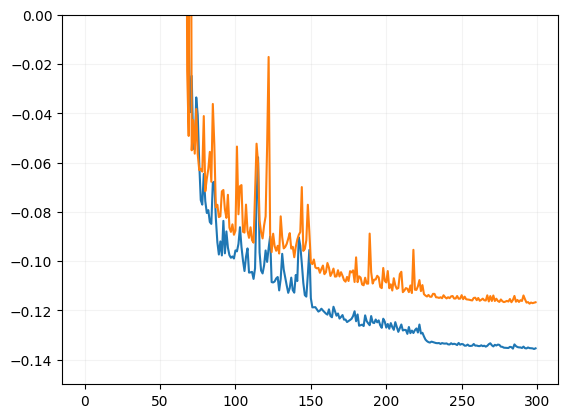

In [11]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.ylim(-0.15, 0)
plt.grid(alpha=0.15)

In [12]:
valid_loss, p, y, subhalo_ids, is_central = validate(valid_loader, model, device=device)

is_central = np.array(is_central).flatten().astype(bool)
p = p.flatten()[is_central]
y = y.flatten()[is_central]

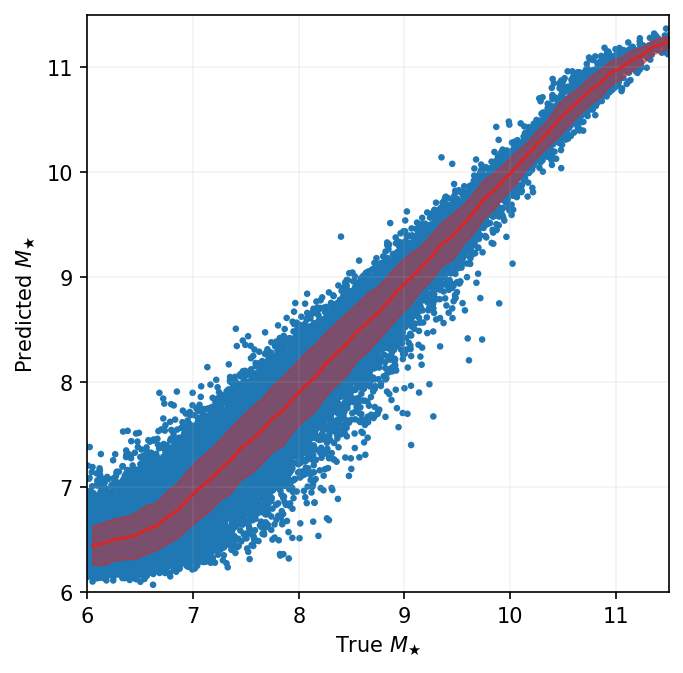

In [13]:
bin_edges = np.arange(6., 12.5, 0.1)
means, *_ = binned_statistic(y, p, statistic="mean", bins=bin_edges)
stds, *_ = binned_statistic(y, p, statistic="std", bins=bin_edges)

plt.figure(figsize=(5,5), dpi=150)
plt.scatter(y, p, s=10, edgecolors="none", )
plt.plot(bin_edges[:-1]+0.05, means, c="C3")
plt.fill_between(bin_edges[:-1]+0.05, means-stds, means+stds, color="C3", alpha=0.5)
plt.xlabel(r"True $M_{\bigstar}$")
plt.ylabel(r"Predicted $M_{\bigstar}$")
plt.grid(alpha=0.15)
plt.xlim(6, 11.5)
plt.ylim(6, 11.5)
plt.show()

In [14]:
def compute_metrics(p, y):
    nmad = median_abs_deviation((p-y), scale="normal")    
    std = np.std(p - y)
    bias = np.mean(p - y)
    f_outlier = np.mean(np.absolute(p-y) > 3*nmad)

    return nmad, std, bias, f_outlier

In [15]:
nmad, std, bias, f_outlier = compute_metrics(p, y.reshape(-1))

print(f"  NMAD scatter     = {nmad:.3f} dex")
print(f"  stdev scatter    = {std:.3f} dex")
print(f"  bias             = {bias:.3f} dex")
print(f"  outlier fraction = {100*f_outlier:.3f}%")

  NMAD scatter     = 0.260 dex
  stdev scatter    = 0.294 dex
  bias             = -0.011 dex
  outlier fraction = 1.753%
